In [17]:
# from transformers import AutoTokenizer, AutoModel, pipeline 
# import torch
# from torch.utils.data import DataLoader, Dataset
# import random 
# import tqdm 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import glob 

In [5]:
model_names = [i.split('/')[-1] for i in glob.glob('//home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/negatives/*')]

In [18]:
positive = [float(i.strip()) for i in open('/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_pos_scores.txt').readlines()]
negative = [float(i.strip()) for i in open('/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_neg_scores.txt').readlines()]
positive_labels = [1 for _ in positive]
negative_labels = [0 for _ in negative]
merged = positive + negative
merged_labels = positive_labels + negative_labels
X = np.array(merged).reshape(-1, 1)
y = np.array(merged_labels)

In [25]:
print(np.mean(positive), np.std(positive))
print(np.mean(negative), np.std(negative))

0.41972634855834007 0.13799025000439427
0.05598411121275754 0.13244710489478906


In [32]:
len(positive), len(negative)

(1618, 25000)

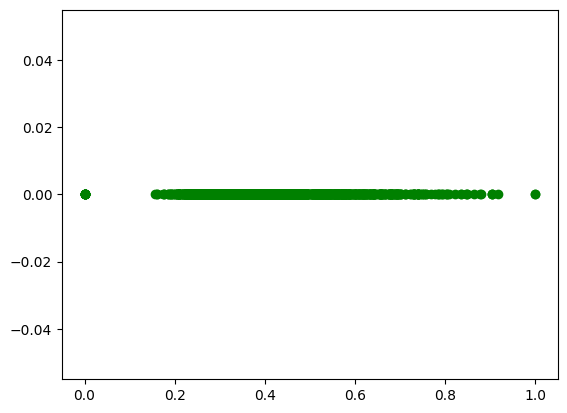

In [30]:
import matplotlib.pyplot as plt
# print positive and negative distributions on number line 
plt.scatter(positive, [0 for _ in positive], color='green') 

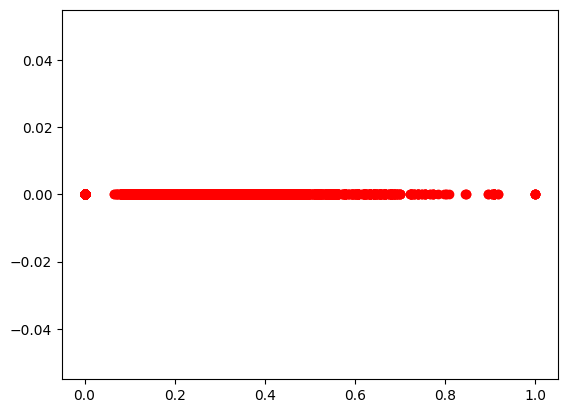

In [31]:
plt.scatter(negative, [0 for _ in negative], color='red')

In [27]:
clf = SVC(kernel='linear')
clf.fit(X, y)
predictions = clf.predict(X)
print('Accuracy: ', accuracy_score(y, predictions))
print('Precision: ', precision_score(y, predictions))
print('Recall: ', recall_score(y, predictions))
print('F1: ', f1_score(y, predictions))

Accuracy:  0.9392140656698474
Precision:  0.0
Recall:  0.0
F1:  0.0


/home2/aditya_hari/miniconda3/envs/textbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
for model_name in ['all-distilroberta-v1_sbert_cont']:
    positives = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/semantic/positives/{model_name}', 'r').readlines()]
    negatives = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/semantic/negatives/{model_name}', 'r').readlines()]
    positive_syn = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_pos_scores.txt', 'r').readlines()]
    negative_syn = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_neg_scores.txt', 'r').readlines()]
    positives_2 = list(zip(positives, positive_syn))
    negatives_2 = list(zip(negatives, negative_syn))
    merged = positives_2 + negatives_2
    positive_labels = [1 for i in positives]
    negative_labels = [0 for i in negatives]
    merged_labels = positive_labels + negative_labels
    # X = np.array(merged).reshape(-1, 1)
    # y = np.array(merged_labels)
    X = np.array(merged)
    y = np.array(merged_labels)
    clf = SVC(kernel='rbf')
    clf.fit(X, y)
    #print(clf.coef_)
    predictions = clf.predict(X)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y, predictions)}")
    print(f"F1: {f1_score(y, predictions)}")
    print(f"Precision: {precision_score(y, predictions)}")
    print(f"Recall: {recall_score(y, predictions)}")

Model: all-distilroberta-v1_sbert_cont
Accuracy: 0.969193778646029
F1: 0.7943831494483451
Precision: 0.6683544303797468
Recall: 0.9789864029666254


In [16]:
for model_name in ['all-distilroberta-v1_sbert_cont']:
    positives = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/semantic/positives/{model_name}', 'r').readlines()]
    negatives = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/semantic/negatives/{model_name}', 'r').readlines()]
    # positive_syn = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_pos_scores.txt', 'r').readlines()]
    # negative_syn = [float(i.strip()) for i in open(f'/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/similarities/syntactic/syntactic_neg_scores.txt', 'r').readlines()]
    # positives_2 = list(zip(positives, positive_syn))
    # negatives_2 = list(zip(negatives, negative_syn))

    merged = positives + negatives
    positive_labels = [1 for i in positives]
    negative_labels = [0 for i in negatives]
    merged_labels = positive_labels + negative_labels
    # X = np.array(merged).reshape(-1, 1)
    # y = np.array(merged_labels)
    X = np.array(merged).reshape(-1, 1)
    y = np.array(merged_labels)
    clf = SVC(kernel='rbf')
    clf.fit(X, y)
    #print(clf.coef_)
    predictions = clf.predict(X)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y, predictions)}")
    print(f"F1: {f1_score(y, predictions)}")
    print(f"Precision: {precision_score(y, predictions)}")
    print(f"Recall: {recall_score(y, predictions)}")

Model: all-distilroberta-v1_sbert_cont
Accuracy: 0.9692313472086558
F1: 0.7974276527331189
Precision: 0.6647422680412371
Recall: 0.9962917181705809


In [42]:
2/7.54246415

0.2651653306167852

In [51]:
predictions = [1 if i > 0.27 else 0 for i in merged]

In [52]:
f1_score(y, predictions)

0.7953705983747846

In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [3]:
sbert_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1")
sbert_model = AutoModel.from_pretrained("sentence-transformers/all-distilroberta-v1").to('cuda')

In [4]:
for param in sbert_model.parameters():
    param.requires_grad = False

In [5]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        self.margin = 0.5
    
    def forward(self, x1, x2, y):
        cos_sim = self.cos(x1, x2)
        loss = torch.mean((1 - y) * torch.pow(cos_sim, 2) + y * torch.pow(torch.nn.functional.relu(self.margin - cos_sim), 2))
        return loss

In [6]:
rdf_model.load_state_dict(torch.load('/scratch/sbert_cont.pt'))

<All keys matched successfully>

## STS results

In [6]:
batch_size = 8

In [7]:
eval_src = open('/home2/aditya_hari/gsoc/data/processed/en/eval_src', 'r').readlines()
eval_tgt = open('/home2/aditya_hari/gsoc/data/processed/en/eval_tgt', 'r').readlines()

eval_src_batched = [eval_src[i:i + batch_size] for i in range(0, len(eval_src), batch_size)]
eval_tgt_batched = [eval_tgt[i:i + batch_size] for i in range(0, len(eval_tgt), batch_size)]

In [12]:
negative_pairs = open('/home2/aditya_hari/gsoc/rdf-to-text/src/seq2seq/negative_pairs.txt').readlines()
neg_src = [p.split('\t')[0] for p in negative_pairs]
neg_tgt = [p.split('\t')[1] for p in negative_pairs]

neg_src_batched = [neg_src[i:i + batch_size] for i in range(0, len(neg_src), batch_size)]
neg_tgt_batched = [neg_tgt[i:i + batch_size] for i in range(0, len(neg_tgt), batch_size)]

#### Base model

In [9]:
rdf_model = AutoModel.from_pretrained("sentence-transformers/all-distilroberta-v1").to('cuda')
rdf_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1")
rdf_tokenizer.add_special_tokens({'additional_special_tokens': ['<TSP>']})
rdf_model.resize_token_embeddings(len(rdf_tokenizer))

Embedding(50266, 768)

### Comparing results before and after pretraining 

In [14]:
similarities = [] 
pb = tqdm.tqdm(total=len(neg_src_batched))
for src, tgt in zip(neg_src_batched, neg_tgt_batched):
    pb.update(1)
    src_tokens = rdf_tokenizer(src, padding=True, truncation=True, max_length=256, return_tensors="pt").to('cuda')
    tgt_tokens = sbert_tokenizer(tgt, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with(torch.no_grad()):
        src_output = rdf_model(**src_tokens)
        src_embedding = mean_pooling(src_output, src_tokens['attention_mask'])

        tgt_output = sbert_model(**tgt_tokens)
        tgt_embedding = mean_pooling(tgt_output, tgt_tokens['attention_mask'].to('cuda'))
    
    similarity = torch.cosine_similarity(src_embedding, tgt_embedding, dim=1)
    similarities.extend(similarity.tolist())

  0%|          | 652/133114 [00:11<39:55, 55.31it/s]

KeyboardInterrupt: 

In [11]:
len(similarities)

2500

In [24]:
similarities = [] 
pb = tqdm.tqdm(total=len(eval_src_batched))
for src, tgt in zip(eval_src_batched, eval_tgt_batched):
    pb.update(1)
    src_tokens = rdf_tokenizer(src, padding=True, truncation=True, max_length=256, return_tensors="pt").to('cuda')
    tgt_tokens = sbert_tokenizer(tgt, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with(torch.no_grad()):
        src_output = rdf_model(**src_tokens)
        src_embedding = mean_pooling(src_output, src_tokens['attention_mask'])

        tgt_output = sbert_model(**tgt_tokens)
        tgt_embedding = mean_pooling(tgt_output, tgt_tokens['attention_mask'].to('cuda'))
    
    similarity = torch.cosine_similarity(src_embedding, tgt_embedding, dim=1)
    similarities.extend(similarity.tolist())

 99%|█████████▊| 200/203 [00:03<00:00, 53.10it/s]

In [25]:
print(np.mean(similarities))

0.6130179136217893


#### After PT

In [28]:
rdf_model = AutoModel.from_pretrained("/scratch/sbert_pt").to('cuda')
rdf_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1")
rdf_tokenizer.add_special_tokens({'additional_special_tokens': ['<TSP>']})
rdf_model.resize_token_embeddings(len(rdf_tokenizer))

Some weights of the model checkpoint at /scratch/sbert_pt were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /scratch/sbert_pt and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Embedding(50266, 768, padding_idx=1)

In [29]:
similarities = [] 
pb = tqdm.tqdm(total=len(eval_src_batched))
for src, tgt in zip(eval_src_batched, eval_tgt_batched):
    pb.update(1)
    src_tokens = rdf_tokenizer(src, padding=True, truncation=True, max_length=256, return_tensors="pt").to('cuda')
    tgt_tokens = sbert_tokenizer(tgt, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with(torch.no_grad()):
        src_output = rdf_model(**src_tokens)
        src_embedding = mean_pooling(src_output, src_tokens['attention_mask'])

        tgt_output = sbert_model(**tgt_tokens)
        tgt_embedding = mean_pooling(tgt_output, tgt_tokens['attention_mask'].to('cuda'))
    
    similarity = torch.cosine_similarity(src_embedding, tgt_embedding, dim=1)
    similarities.extend(similarity.tolist())

 99%|█████████▉| 201/203 [00:03<00:00, 51.87it/s]

In [30]:
print(np.mean(similarities))

0.2536468929455734


### Before and after CT

#### After CT

In [48]:
rdf_model = AutoModel.from_pretrained("/scratch/sbert_pt").to('cuda')
rdf_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1")
rdf_tokenizer.add_special_tokens({'additional_special_tokens': ['<TSP>']})
rdf_model.resize_token_embeddings(len(rdf_tokenizer))
rdf_model.load_state_dict(torch.load('/scratch/sbert_cont.pt'))

Some weights of the model checkpoint at /scratch/sbert_pt were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /scratch/sbert_pt and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

<All keys matched successfully>

In [38]:
similarities = [] 
pb = tqdm.tqdm(total=len(eval_src_batched))
for src, tgt in zip(eval_src_batched, eval_tgt_batched):
    pb.update(1)
    src_tokens = rdf_tokenizer(src, padding=True, truncation=True, max_length=256, return_tensors="pt").to('cuda')
    tgt_tokens = sbert_tokenizer(tgt, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with(torch.no_grad()):
        src_output = rdf_model(**src_tokens)
        src_embedding = mean_pooling(src_output, src_tokens['attention_mask'])

        tgt_output = sbert_model(**tgt_tokens)
        tgt_embedding = mean_pooling(tgt_output, tgt_tokens['attention_mask'].to('cuda'))
    
    similarity = torch.cosine_similarity(src_embedding, tgt_embedding, dim=1)
    similarities.extend(similarity.tolist())

100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


In [39]:
print(np.mean(similarities))

0.4009707574312413


### RoBERTa

In [ ]:
rdf_model = AutoModel.from_pretrained("sentence-transformers/all-distilroberta-v1").to('cuda')
rdf_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1")
rdf_tokenizer.add_special_tokens({'additional_special_tokens': ['<TSP>']})
rdf_model.resize_token_embeddings(len(rdf_tokenizer))

In [38]:
fill_mask = pipeline("fill-mask", model="/scratch/checkpoint-550000/", tokenizer="sentence-transformers/all-distilroberta-v1") 

In [39]:
result = fill_mask("Adirondack_Regional_Airport | <mask> | 507")
print(result)

[{'score': 0.8828219771385193, 'token': 28697, 'token_str': ' homepage', 'sequence': 'Adirondack_Regional_Airport | homepage | 507'}, {'score': 0.04009265452623367, 'token': 13561, 'token_str': ' id', 'sequence': 'Adirondack_Regional_Airport | id | 507'}, {'score': 0.016668234020471573, 'token': 2148, 'token_str': ' capacity', 'sequence': 'Adirondack_Regional_Airport | capacity | 507'}, {'score': 0.011269346810877323, 'token': 6332, 'token_str': ' membership', 'sequence': 'Adirondack_Regional_Airport | membership | 507'}, {'score': 0.009001060388982296, 'token': 43715, 'token_str': ' garrison', 'sequence': 'Adirondack_Regional_Airport | garrison | 507'}]


In [12]:
result = fill_mask("Brazil | capital | <mask>")
print(result)

[{'score': 0.4451245069503784, 'token': 24435, 'token_str': ' Lisbon', 'sequence': 'Brazil | capital | Lisbon'}, {'score': 0.4019171893596649, 'token': 2910, 'token_str': ' Brazil', 'sequence': 'Brazil | capital | Brazil'}, {'score': 0.04149125516414642, 'token': 20698, 'token_str': ' Janeiro', 'sequence': 'Brazil | capital | Janeiro'}, {'score': 0.012677792459726334, 'token': 5716, 'token_str': ' Rio', 'sequence': 'Brazil | capital | Rio'}, {'score': 0.007810568902641535, 'token': 8947, 'token_str': ' Rome', 'sequence': 'Brazil | capital | Rome'}]


In [16]:
result = fill_mask("<mask> | league | English Premier League")
print(result)

[{'score': 0.17329764366149902, 'token': 26698, 'token_str': 'England', 'sequence': 'England | league | English Premier League'}, {'score': 0.02372707426548004, 'token': 48772, 'token_str': 'Offset', 'sequence': 'Offset | league | English Premier League'}, {'score': 0.017689764499664307, 'token': 46525, 'token_str': 'Title', 'sequence': 'Title | league | English Premier League'}, {'score': 0.016985008493065834, 'token': 31661, 'token_str': 'Arsenal', 'sequence': 'Arsenal | league | English Premier League'}, {'score': 0.01610775850713253, 'token': 36571, 'token_str': 'Spain', 'sequence': 'Spain | league | English Premier League'}]


In [18]:
result = fill_mask("Aleksandre_Guruli | team | <mask>")
print(result)


[{'score': 0.14582443237304688, 'token': 22514, 'token_str': ' Belarus', 'sequence': 'Aleksandre_Guruli | team | Belarus'}, {'score': 0.13682851195335388, 'token': 798, 'token_str': ' Russia', 'sequence': 'Aleksandre_Guruli | team | Russia'}, {'score': 0.03605753928422928, 'token': 4644, 'token_str': ' Greece', 'sequence': 'Aleksandre_Guruli | team | Greece'}, {'score': 0.02975333109498024, 'token': 12097, 'token_str': ' Azerbaijan', 'sequence': 'Aleksandre_Guruli | team | Azerbaijan'}, {'score': 0.02689189277589321, 'token': 19848, 'token_str': ' Bulgaria', 'sequence': 'Aleksandre_Guruli | team | Bulgaria'}]


In [7]:
rdf_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
rdf_model = AutoModel.from_pretrained("/scratch/checkpoint-400000").to('cuda')

rdf_tokenizer.add_special_tokens({'additional_special_tokens': ['<TSP>']})
rdf_model.resize_token_embeddings(len(rdf_tokenizer))

Some weights of the model checkpoint at /scratch/checkpoint-400000 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /scratch/checkpoint-400000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Embedding(50266, 768)

In [8]:
rdf_model.load_state_dict(torch.load('/scratch/rdf_model_4.pt'))

<All keys matched successfully>

In [49]:
rdf = "Sachin Tendulkar | occupation | cricketer"
rdf_tokens = rdf_tokenizer(rdf, return_tensors='pt').to('cuda')
rdf_output = rdf_model(**rdf_tokens)
rdf_embedding = mean_pooling(rdf_output, rdf_tokens['attention_mask'])

In [54]:
sent = "Ramesh is a cricketer."
sent_tokens = sbert_tokenizer(sent, return_tensors='pt').to('cuda')
sent_output = sbert_model(**sent_tokens)
sent_embedding = mean_pooling(sent_output, sent_tokens['attention_mask'])

In [55]:
torch.cosine_similarity(rdf_embedding, sent_embedding, dim=1)

tensor([0.3052], device='cuda:0', grad_fn=<SumBackward1>)

In [8]:
train_src_lines = open("/home2/aditya_hari/gsoc/nabu/data/processed_data/eng/train_src", 'r').readlines()
train_tgt_lines = open("/home2/aditya_hari/gsoc/nabu/data/processed_data/eng/train_tgt", 'r').readlines()

In [9]:
train_rdfs = {}
for src, tgt in zip(train_src_lines, train_tgt_lines):
    if(src.strip() not in train_rdfs):
        train_rdfs[src.strip()] = []
    train_rdfs[src.strip()].append(tgt.strip())

In [40]:
keys = list(train_rdfs.keys())

In [39]:
positive_pairs = []
for src in train_rdfs:
    for tgt in train_rdfs[src]:
        positive_pairs.append((src, tgt))

In [57]:
negative_pairs = []
pb = tqdm.tqdm(total=len(train_rdfs))
for src in train_rdfs:
    pb.update(1)
    for tgt in train_rdfs[src]:
        non_srcs = random.sample(keys, 31)
        while src not in non_srcs:
            non_srcs = random.sample(keys, 31)
        for non_src in non_srcs:
            negative_pairs.append((src, random.choice(train_rdfs[non_src])))

100%|█████████▉| 12791/12796 [03:08<00:00, 76.57it/s]

In [58]:
len(positive_pairs), len(negative_pairs)

(34352, 1064912)

In [59]:
with(open('positive_pairs.txt', 'w')) as f:
    for src, tgt in positive_pairs:
        f.write(src + '\t' + tgt + '\n')

with(open('negative_pairs.txt', 'w')) as f:
    for src, tgt in negative_pairs:
        f.write(src + '\t' + tgt + '\n')

In [62]:
negative_pointer = 0 
training_pairs = []
for positive in positive_pairs:
    training_pairs.append(positive) 
    training_pairs.extend(negative_pairs[negative_pointer: negative_pointer + 31])
    negative_pointer += 31

In [70]:
train_labels = []
for i in range(len(training_pairs)):
    if(i % 32 == 0):
        train_labels.append(1)
    else:
        train_labels.append(0)

In [121]:
with(open("positive_pairs.txt", 'w')) as f:
    for src, tgt in positive_pairs:
        f.write(src + '\t' + tgt + '\n')

with(open("negative_pairs.txt", 'w')) as f:
    for src, tgt in negative_pairs:
        f.write(src + '\t' + tgt + '\n')

In [7]:
positive_pairs = [p.split('\t') for p in open("positive_pairs.txt", 'r').readlines()]
negative_pairs = [p.split('\t') for p in open("negative_pairs.txt", 'r').readlines()]

negative_pointer = 0 
training_pairs = []
for positive in positive_pairs:
    training_pairs.append(positive) 
    training_pairs.extend(negative_pairs[negative_pointer: negative_pointer + 7])
    negative_pointer += 31

train_labels = []
for i in range(len(training_pairs)):
    if(i % 8 == 0):
        train_labels.append(1)
    else:
        train_labels.append(0)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, pairs, labels, rdf_tokenizer, sbert_tokenizer):
        self.pairs = pairs
        self.labels = labels
        self.rdf_tokenizer = rdf_tokenizer
        self.sbert_tokenizer = sbert_tokenizer
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rdf, text = self.pairs[idx]
        rdf_encodings = self.rdf_tokenizer(rdf, truncation=True, padding='max_length', max_length=256, return_tensors='pt')
        text_encodings = self.sbert_tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')

        return rdf_encodings, text_encodings, torch.tensor(self.labels[idx])


In [9]:
train_dataset = CustomDataset(training_pairs[:33352*8], train_labels[:33352*8], rdf_tokenizer, sbert_tokenizer)
eval_dataset = CustomDataset(training_pairs[33352*8:], train_labels[33352*8:], rdf_tokenizer, sbert_tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

In [13]:
optimizer = torch.optim.Adam(rdf_model.parameters(), lr=5e-5)
loss_fn = ContrastiveLoss()

In [15]:
for epoch in range(5):
    pb_train = tqdm.tqdm(total=len(train_dataloader))
    train_losses = [] 
    for batch in train_dataloader:
        optimizer.zero_grad()
        rdf_encodings, text_encodings, labels = batch
        rdf_encodings = {key: val.to('cuda').squeeze() for key, val in rdf_encodings.items()}
        text_encodings = {key: val.to('cuda').squeeze() for key, val in text_encodings.items()}
        rdf_outputs = rdf_model(**rdf_encodings)
        text_outputs = sbert_model(**text_encodings)

        rdf_embedding = mean_pooling(rdf_outputs, rdf_encodings['attention_mask'])
        text_embedding = mean_pooling(text_outputs, text_encodings['attention_mask'])

        loss = loss_fn(rdf_embedding, text_embedding, labels.to('cuda'))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
        pb_train.set_description("Epoch: {}, Loss: {}".format(epoch, np.mean(train_losses)))
        pb_train.update(1)
    pb_train.close()
    print("Epoch: {}, Train Loss: {}".format(epoch, np.mean(train_losses)))

    pb_eval = tqdm.tqdm(total=len(eval_dataloader))
    eval_losses = []
    for batch in eval_dataloader:
        rdf_encodings, text_encodings, labels = batch
        rdf_encodings = {key: val.to('cuda').squeeze() for key, val in rdf_encodings.items()}
        text_encodings = {key: val.to('cuda').squeeze() for key, val in text_encodings.items()}
        rdf_outputs = rdf_model(**rdf_encodings)
        text_outputs = sbert_model(**text_encodings)

        rdf_embedding = mean_pooling(rdf_outputs, rdf_encodings['attention_mask'])
        text_embedding = mean_pooling(text_outputs, text_encodings['attention_mask'])

        loss = loss_fn(rdf_embedding, text_embedding, labels.to('cuda'))
        eval_losses.append(loss.item())
        pb_eval.set_description("Epoch: {}, Loss: {}".format(epoch, np.mean(eval_losses)))
        pb_eval.update(1)
    pb_eval.close()
    print("Epoch: {}, Eval Loss: {}".format(epoch, np.mean(eval_losses)))
    torch.save(rdf_model.state_dict(), '/scratch/rdf_model_{}.pt'.format(epoch))


Epoch: 0, Loss: 0.003210941795259714:   0%|          | 82/33352 [00:13<1:32:02,  6.02it/s] 

KeyboardInterrupt: 